In this notebook the GENDER CLASSIFICATION TASK on the Librispeech dataset will be carried out. In particular, as suggested in the task description, the MFCC will be extracted and on top of them the classification algorithms will be build. In this notebook a Random Forest, an SVM classifier, a NN and a CNN will be applied.

In [5]:
import pandas as pd
import numpy as np
import os
import re
import random
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import itertools
import datetime


from IPython.display import Audio
from rich.progress import track
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve


In [6]:
%run utils_function_1.py

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In order to understand the Librispeech dataseta we've read the documentation

In [7]:
# dataset_path = '/home/pierobon/Voiseed_task/dev_clean/LibriSpeech/README.TXT'
# f = open(dataset_path, "r")
# print(f.read())

In [8]:
# dataset_path = '/home/pierobon/Voiseed_task/dev_clean/LibriSpeech/SPEAKERS.TXT'
# f = open(dataset_path, "r")
# print(f.read())

After that, we organize in a dataframe all the audio files that we have in dev-clean with some interesti information, like:
- ID: ID of the speaker 
- chapter: chapter read by the speaker
- path


In [9]:
data = []
dataset_path = '/home/pierobon/Voiseed_task/dev_clean/LibriSpeech/dev-clean/'
for speaker in sorted(os.listdir(dataset_path)):
    for chapter in sorted(os.listdir(dataset_path+speaker)):
        for file in sorted(os.listdir(dataset_path+speaker+'/'+chapter)):
            if file.endswith(".flac"):
                data.append((speaker, chapter, dataset_path+speaker+'/'+chapter+'/'+file))

df_audio = pd.DataFrame(data, columns=['ID', 'Chapter', 'path'])
df_audio['ID'] = df_audio['ID'].astype(int)
df_audio['Chapter'] = df_audio['Chapter'].astype(int)

df_audio.head()

,ID,Chapter,path
0,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
1,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
2,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
3,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
4,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...


since we have some problems in reading the line 45 of the file SPEAKERS.TXT because of the name of the speaker includes the delemiter '|', 
we clean that row directly from the original txt file

In [10]:
with open('/home/pierobon/Voiseed_task/dev_clean/LibriSpeech/SPEAKERS.TXT', 'r') as file:
    filedata = file.read()
# Replace the target string
filedata = filedata.replace('|CBW|', 'CBW')
# Write the file out again
with open('/home/pierobon/Voiseed_task/dev_clean/LibriSpeech/SPEAKERS.TXT', 'w') as file:
    file.write(filedata)

In [11]:
# importing df_speaker
df_speaker = pd.read_csv('/home/pierobon/Voiseed_task/dev_clean/LibriSpeech/SPEAKERS.TXT', sep='|', error_bad_lines=False, skiprows=11)

# formatting df_speaker
df_speaker.columns = ['ID', 'SEX', 'SUBSET', 'MINUTES', 'NAME']
df_speaker.SEX = df_speaker.SEX.str.strip()
df_speaker.SUBSET = df_speaker.SUBSET.astype(str)
df_speaker.MINUTES = df_speaker.MINUTES.astype(float)

In [12]:
df_speaker

,ID,SEX,SUBSET,MINUTES,NAME
0,14,F,train-clean-360,25.03,Kristin LeMoine
1,16,F,train-clean-360,25.11,Alys AtteWater
2,17,M,train-clean-360,25.04,Gord Mackenzie
3,19,F,train-clean-100,25.19,Kara Shallenberg
4,20,F,train-other-500,30.07,Gesine
...,...,...,...,...,...
2479,8975,F,train-clean-100,25.11,Daisy Flaim
2480,9000,M,train-other-500,27.26,Ramon Escamilla
2481,9022,F,train-clean-360,25.17,Claire M
2482,9023,F,train-clean-360,25.19,P. J. Morgan


In [13]:
df_total = df_audio.merge(df_speaker[['ID', 'SEX', 'NAME']], how='left', on='ID')

we've decided not to include in the merge the MINUTES column (because it represents the total duration per speaker and not per audio file)
and the SUBSET column because is not relevant for our analysis. 

In [14]:
pd.DataFrame(df_total.groupby(by='SEX', axis=0).count())[['path']]

,path
SEX,
F,1374
M,1329


the dataset is gender balanced in terms of # audio segment 

In [15]:
df_total.groupby(by=['Chapter', 'ID'], ).count().reset_index()[['Chapter', 'ID']].value_counts().unique()

array([1])

each chapter is read by only one speaker

In [16]:
df_total

,ID,Chapter,path,SEX,NAME
0,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
1,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
2,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
3,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
4,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
...,...,...,...,...,...
2698,8842,304647,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,Mary J
2699,8842,304647,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,Mary J
2700,8842,304647,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,Mary J
2701,8842,304647,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,Mary J


# Preliminary analysis

with this analysis we'll listen to some audio tracks in order to get a clearer idea about the Librispeach dataset 

In [17]:
sample = df_total.iloc[1, :]
audio_tensor, sr = torchaudio.load(sample.path)
Audio(audio_tensor[0,:].numpy().transpose(), rate=sr)

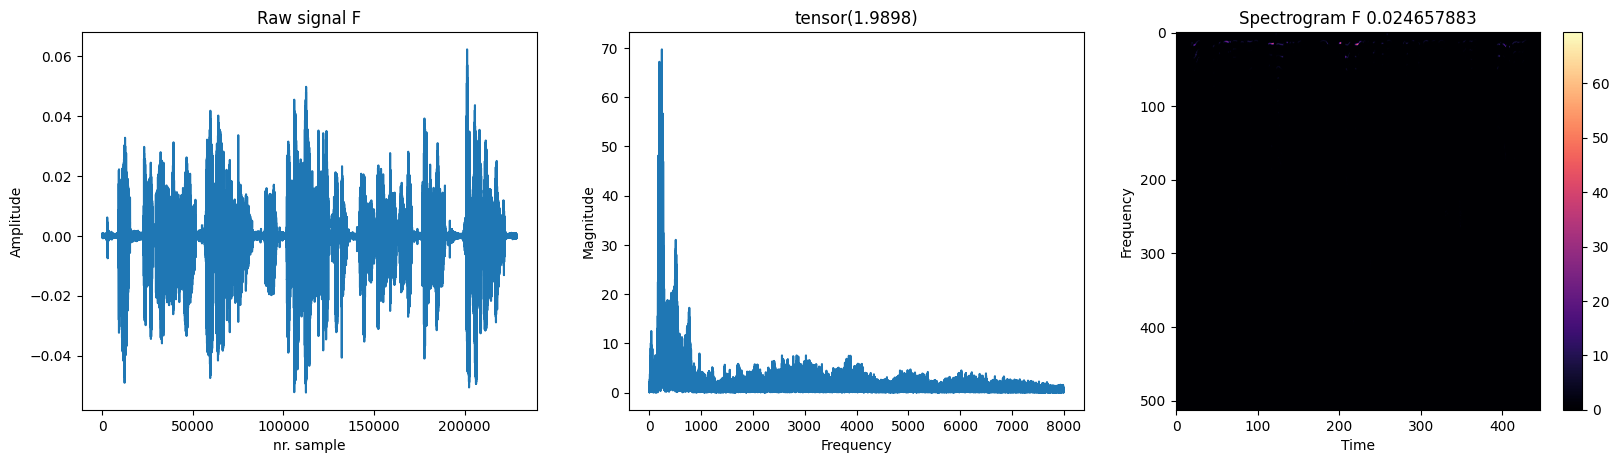

In [18]:
preliminary_plot(df_total.iloc[410, :])

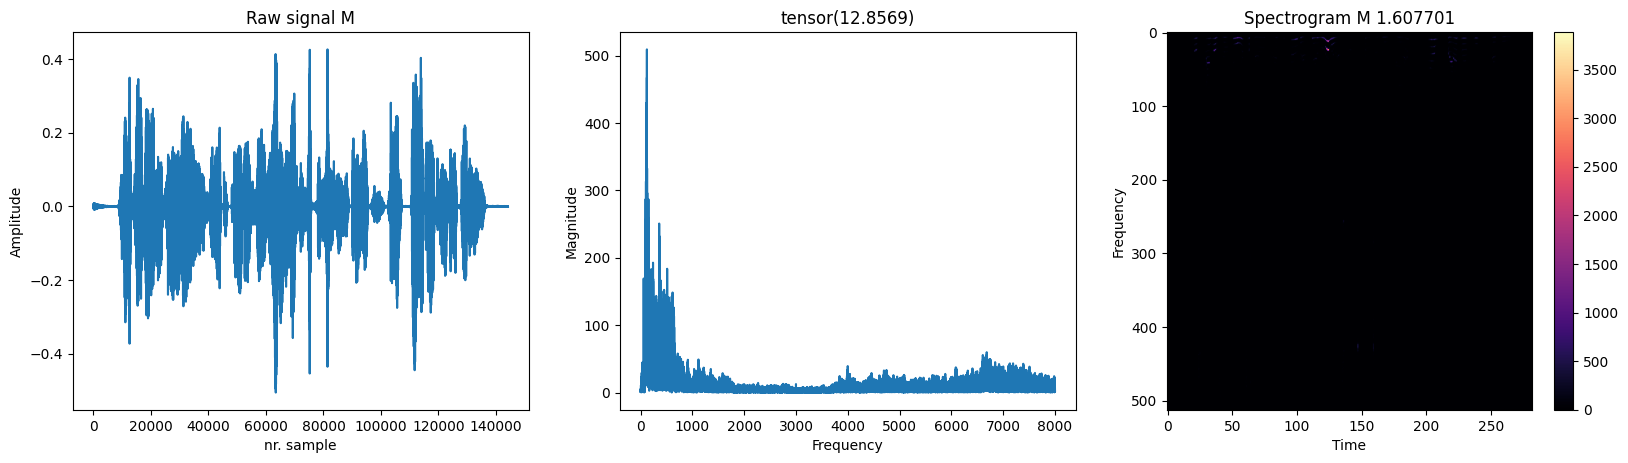

In [19]:
preliminary_plot(df_total.iloc[5, :])

plotting different samples we've observed that the low-frequency bands are more significant than the others. At the same time, 
we can't discard the high frequency bands, with a resampling for instance, because we've notice some qualitative differences arcross the 
different genres (see plot Frequency-Magnitude)

Once we have the dataset with all the information needed for the analysis (df_total), we can proceed calculating the MFCC, 
as suggested in the task description.

# MFCC

In [21]:
df_mfcc = calculate_MFCC(df_total, 64)

Output()

/home/pierobon/.conda/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


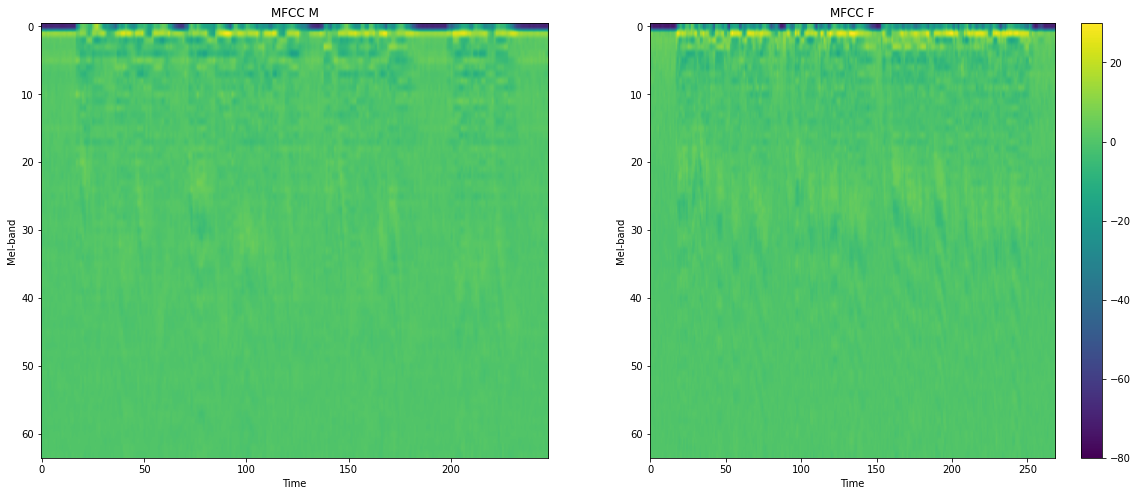

In [26]:
# plotting random sample for each category (M/F)

sample_m = df_mfcc[df_mfcc.SEX == 'M'].mfcc.sample(n=1, axis=0)
sample_f = df_mfcc[df_mfcc.SEX == 'F'].mfcc.sample(n=1, axis=0)

fig, ax = plt.subplots(1,2, figsize=(20,8))
im = ax[0].imshow(sample_m.item().numpy(), aspect=('auto'), vmin=-80, vmax=30)
ax[0].set_title('MFCC M', fontsize = 12)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Mel-band")

ax[1].imshow(sample_f.item().numpy(), aspect=('auto'), vmin=-80, vmax=30)
ax[1].set_title('MFCC F', fontsize = 12)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Mel-band")

fig.colorbar(im)
fig.show()

as we can see, we have audio tracks with different durations

In [27]:
# calculate the audio embeddings by doing the mean for each mel-band over the time dimension

df_mfcc_metrics = calculate_band_metrics(df_total, 64)

Output()

we want to plot the mean of each mel-band (per category) in order to observe some macro differences between M and F


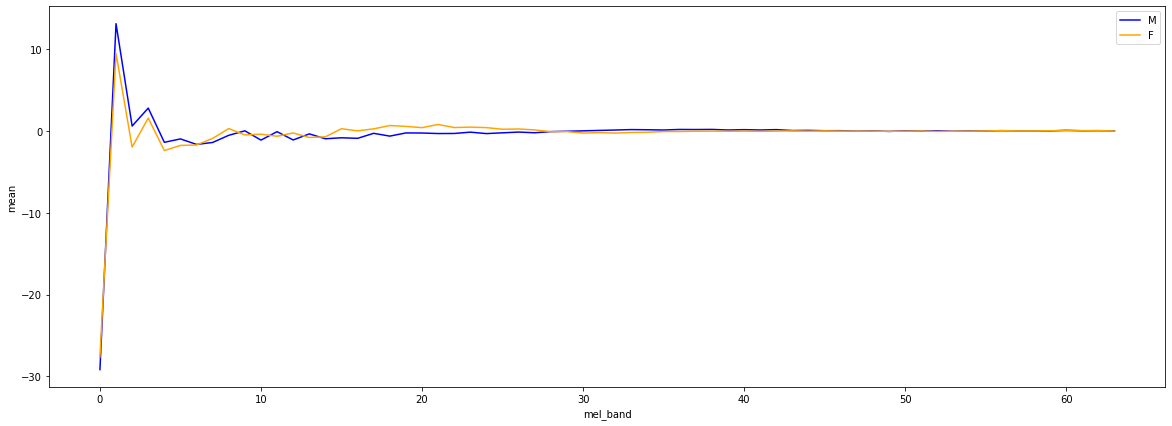

In [30]:
# divide M/F
df_mfcc_metrics_male = df_mfcc_metrics[df_mfcc_metrics.SEX == 'M'].reset_index(drop=True)
df_mfcc_metrics_female = df_mfcc_metrics[df_mfcc_metrics.SEX == 'F'].reset_index(drop=True)

# plot
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(df_mfcc_metrics_male.describe().iloc[1,:], color='blue', label='M')
ax.plot(df_mfcc_metrics_female.describe().iloc[1,:], color='orange', label='F')
ax.set_xlabel('mel_band')
ax.set_ylabel('mean')
ax.legend()
fig.show()

since we've noticed a difference in terms of mean of each mel band along the time dimension between M and F, we plot in a boxplot the distribution of the mean of first 30 mel bands over the time.

(-1.0, 31.0)

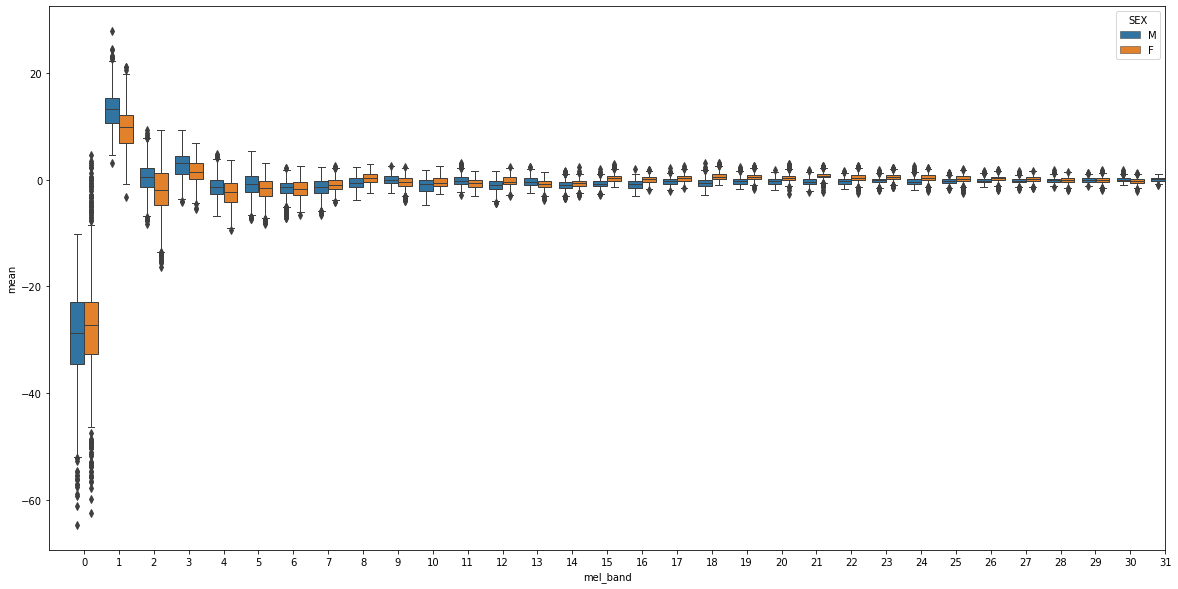

In [31]:
df_mfcc_metrics_male_melt = df_mfcc_metrics_male.iloc[:, :64].melt(var_name='mel_band', value_name='mean')
df_mfcc_metrics_male_melt['SEX'] = 'M'

df_mfcc_metrics_female_melt = df_mfcc_metrics_female.iloc[:, :64].melt(var_name='mel_band', value_name='mean')
df_mfcc_metrics_female_melt['SEX'] = 'F'

df_mfcc_metrics_tot_melt = pd.concat([df_mfcc_metrics_male_melt, df_mfcc_metrics_female_melt], axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize = (20, 10))
sns.boxplot(ax=ax, x='mel_band', y="mean", data=df_mfcc_metrics_tot_melt, linewidth=1, hue='SEX')
ax.set_xlim(-1,31)
# ax.set_ylim(-20,20)

from this boxplot we can outline a difference between M and F which is concentrated in the first 30 mel bands.

In [32]:
df_mfcc_metrics_male.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,...,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000
mean,-29.171240,13.102139,0.593110,2.786011,-1.395774,-0.981953,-1.655763,-1.414700,-0.540168,0.007062,...,0.003901,-0.002903,0.026467,0.011137,0.010765,-0.002913,0.065899,0.015169,0.026550,0.008049
std,8.186350,3.603288,3.014678,2.200595,2.037391,2.201361,1.550725,1.650386,1.195468,0.866567,...,0.119524,0.125946,0.098517,0.101474,0.094797,0.095650,0.086860,0.073772,0.084417,0.077029
min,-64.770058,3.134677,-8.372142,-4.229975,-6.758692,-7.449211,-7.225361,-6.709463,-3.890205,-2.428167,...,-0.391793,-0.486892,-0.350561,-0.377195,-0.249474,-0.363070,-0.267933,-0.307731,-0.320835,-0.297344
25%,-34.559055,10.550774,-1.416559,1.145501,-2.749546,-2.325293,-2.449887,-2.428249,-1.425142,-0.622428,...,-0.076404,-0.071444,-0.032649,-0.044190,-0.053102,-0.060595,0.007273,-0.031284,-0.027244,-0.039924
50%,-28.822975,13.176461,0.508038,3.092212,-1.385451,-0.868071,-1.399089,-1.364190,-0.546570,-0.062330,...,0.000177,0.012091,0.027767,0.014919,0.014299,0.005896,0.059979,0.017644,0.027636,0.004403
75%,-22.902636,15.315155,2.258127,4.408257,-0.072460,0.744267,-0.654309,-0.151475,0.357456,0.632743,...,0.073731,0.079566,0.088308,0.071905,0.068638,0.057610,0.120233,0.061913,0.081850,0.051594
max,-10.125179,27.875992,9.309082,9.291694,4.873495,5.317110,2.208538,2.306521,2.383589,2.528997,...,0.498345,0.339364,0.283059,0.324633,0.384334,0.311048,0.488964,0.228790,0.352265,0.286796


we've tried to do the same considering the standard deviation (and other features) of each mel band over the time

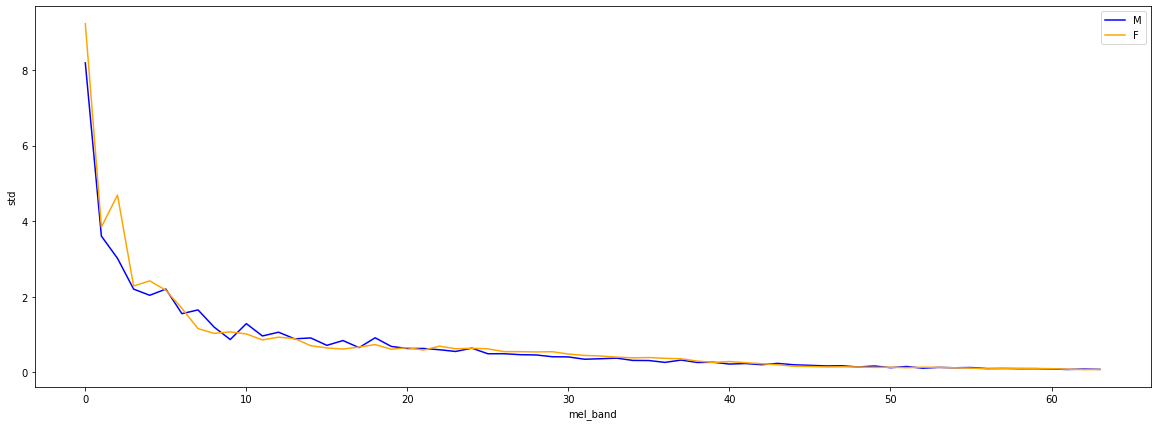

In [33]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(df_mfcc_metrics_male.describe().iloc[2,:], color='blue', label='M')
ax.plot(df_mfcc_metrics_female.describe().iloc[2,:], color='orange', label='F')
ax.set_xlabel('mel_band')
ax.set_ylabel('std')
ax.legend()
fig.show()

the standard deviation, min, max, 25%, median, 75% and max do not represent a better disciminative feature for this task than the mean 

# Scaling the embeddings

First of all we want to verify that the distribution of each mel band is normal, otherwise we can have some issues with the standard scaler


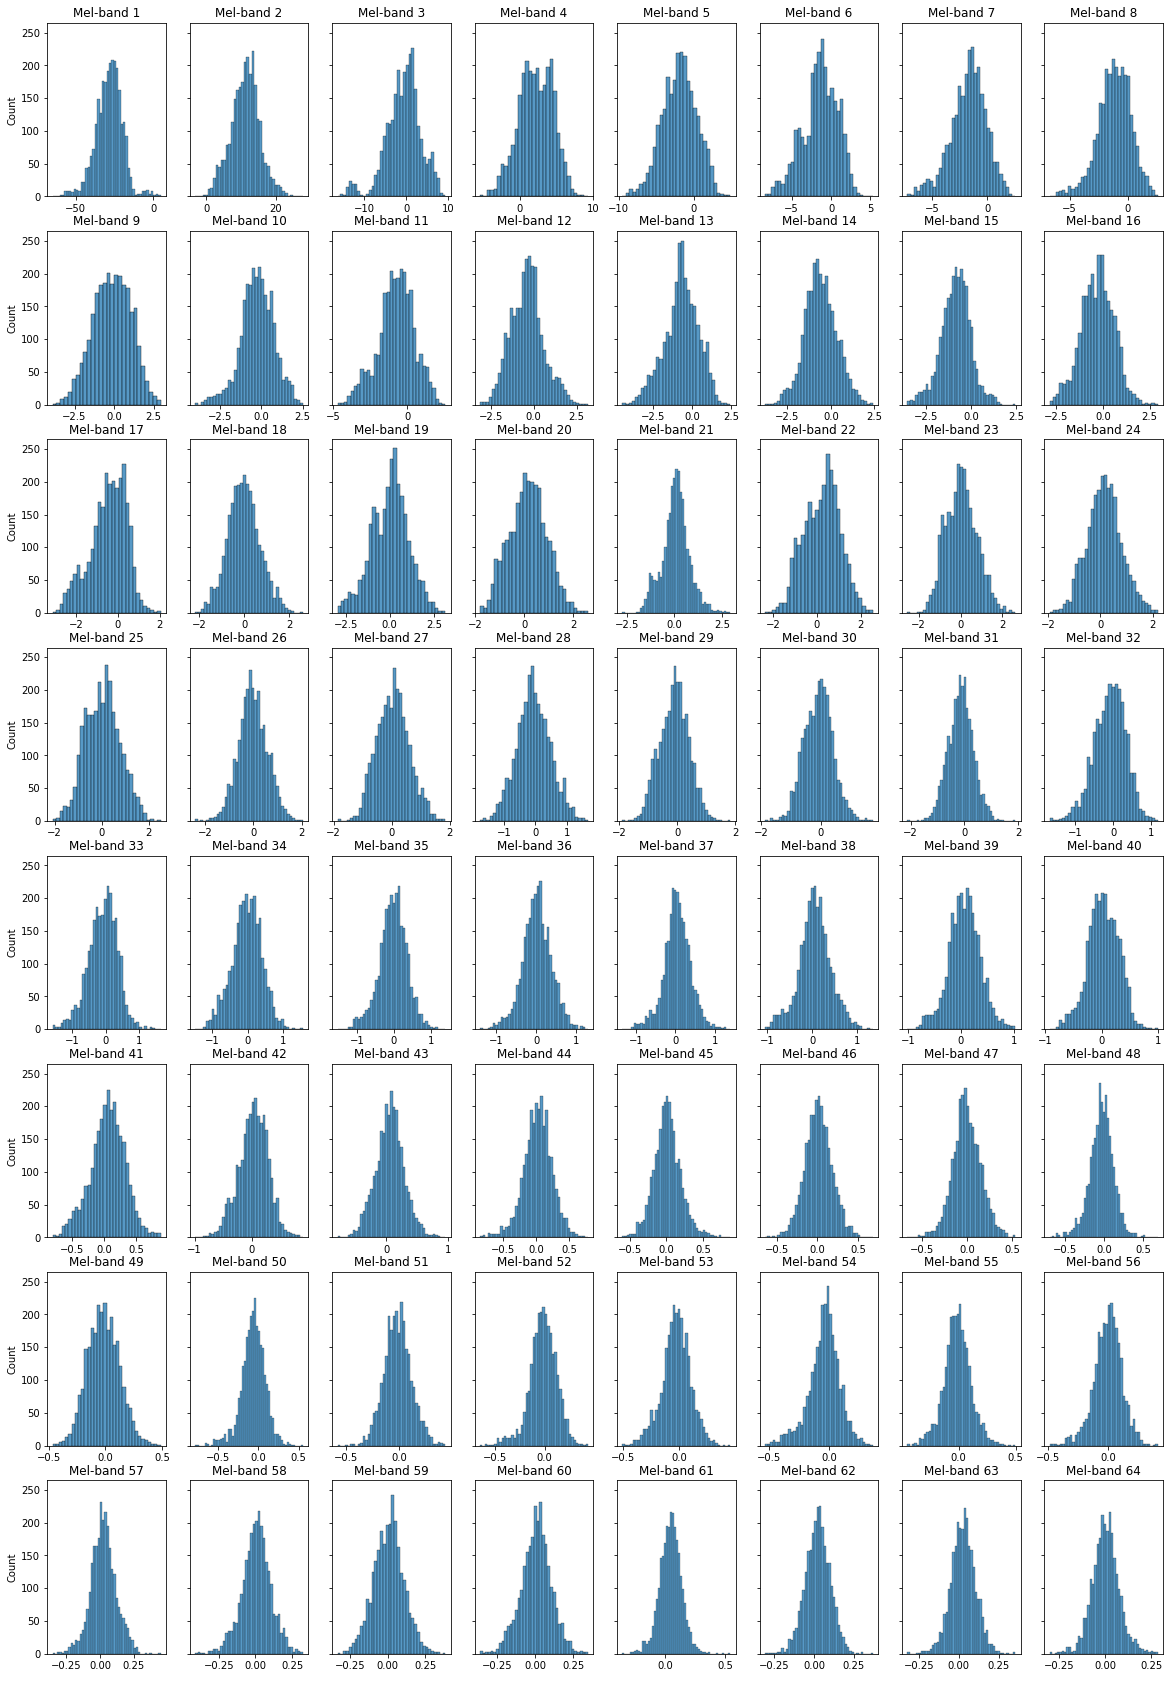

In [83]:
fig, ax = plt.subplots(nrows=8, ncols=8, figsize = (20,30), sharey=True)
i=0
for row in range(8):
    for col in range(8):
        sns.histplot(ax=ax[row, col], data=(df_mfcc_metrics.iloc[:, i]))
        i+=1
        ax[row, col].set_xlabel(' ')
        ax[row, col].set_title('Mel-band '+str(i))
fig.show()

From here we can assume that the mel-bands are distributed in a normal way, thus we can apply the standard scaler

In [37]:
# scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_mfcc_scaled_metrics = pd.DataFrame(scaler.fit_transform(df_mfcc_metrics.iloc[:, :64]))
df_mfcc_scaled_metrics['path'] = df_mfcc_metrics.path
df_mfcc_scaled_metrics['SEX'] = df_mfcc_metrics.SEX

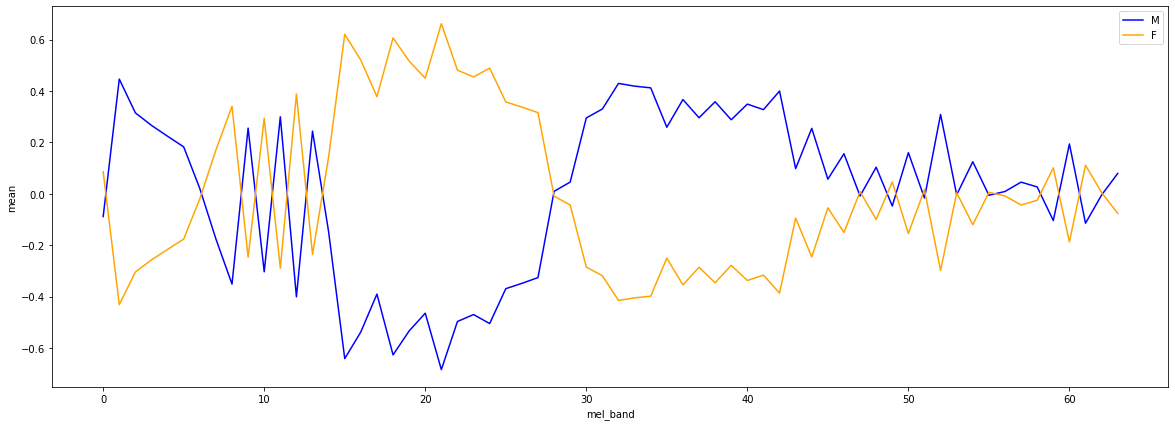

In [38]:
# divide M/F
df_mfcc_scaled_metrics_male = df_mfcc_scaled_metrics[df_mfcc_scaled_metrics.SEX == 'M'].reset_index(drop=True)
df_mfcc_scaled_metrics_female = df_mfcc_scaled_metrics[df_mfcc_scaled_metrics.SEX == 'F'].reset_index(drop=True)

# plot
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(df_mfcc_scaled_metrics_male.describe().iloc[1,:], color='blue', label='M')
ax.plot(df_mfcc_scaled_metrics_female.describe().iloc[1,:], color='orange', label='F')
ax.set_xlabel('mel_band')
ax.set_ylabel('mean')
ax.legend()
fig.show()

since we've noticed a difference in terms of mean of each mel band along the time dimension between M and F, as we did before, we plot in a boxplot the distribution of the mean over the time of each mel band.

<AxesSubplot:xlabel='mel_band', ylabel='mean'>

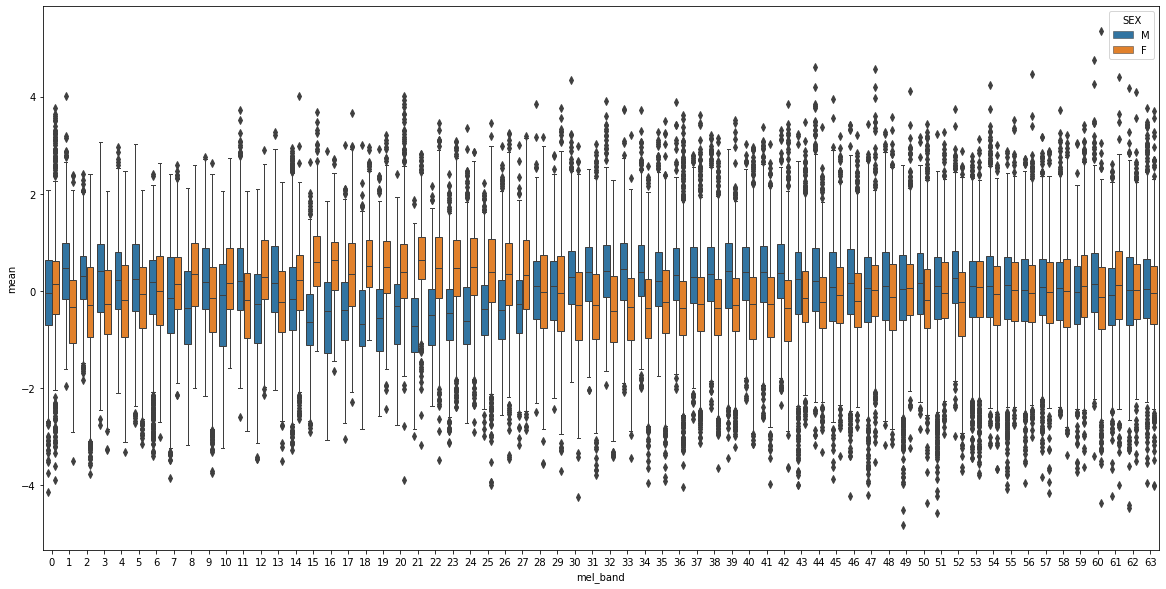

In [39]:
df_mfcc_scaled_metrics_male_melt = df_mfcc_scaled_metrics_male.iloc[:, :64].melt(var_name='mel_band', value_name='mean')
df_mfcc_scaled_metrics_male_melt['SEX'] = 'M'

df_mfcc_scaled_metrics_female_melt = df_mfcc_scaled_metrics_female.iloc[:, :64].melt(var_name='mel_band', value_name='mean')
df_mfcc_scaled_metrics_female_melt['SEX'] = 'F'

df_mfcc_scaled_metrics_tot_melt = pd.concat([df_mfcc_scaled_metrics_male_melt, df_mfcc_scaled_metrics_female_melt], axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize = (20, 10))
sns.boxplot(ax=ax, x='mel_band', y="mean", data=df_mfcc_scaled_metrics_tot_melt, linewidth=1, hue='SEX')
# ax.set_xlim(-1,40)
# ax.set_ylim(-20,20)

scaling the embeddings (mean of each mel-band over the time dimension) we can observe a greater difference between M/F which is concentrated in different mel-bands than with the non-scaled embeddings

# Outlier detection

for each embeddings we calculate the mean of the mel-bands in order to observe if there are some outliers

In [41]:
df_potential_outlier = pd.DataFrame({'mean': np.mean(df_mfcc_scaled_metrics[range(0,64)], axis=1),\
                                     'path': df_mfcc_scaled_metrics.path,\
                                     'SEX': df_mfcc_scaled_metrics.SEX})

<AxesSubplot:xlabel='SEX', ylabel='mean'>

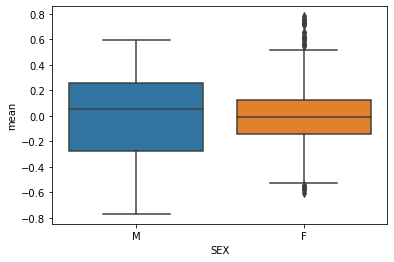

In [42]:
sns.boxplot(data=df_potential_outlier, x='SEX', y='mean')

only the female class presents some outlier (we've identified as outlier the audio files which are not included into the [lower_whiscker, upper_whiscker])

In [43]:
# upper whisker = q3 + 1.5 IQR
# lower whisker = q1 - 1.5 IQR

q3_female = df_potential_outlier.loc[df_potential_outlier.SEX == 'F', 'mean'].describe().iloc[6]
q1_female = df_potential_outlier.loc[df_potential_outlier.SEX == 'F', 'mean'].describe().iloc[4]
upper_whiscker_female = q3_female + 1.5*(q3_female - q1_female)
lower_whiscker_female = q1_female - 1.5*(q3_female - q1_female)

# we've identified as outlier the audio files which are not included into the [lower_whiscker, upper_whiscker]

df_outlier_female = df_potential_outlier[(df_potential_outlier.SEX == 'F') &\
                                         ((df_potential_outlier['mean'] >= upper_whiscker_female) |\
                                          (df_potential_outlier['mean'] <= lower_whiscker_female))]

df_outlier_female = df_outlier_female.merge(df_total[['ID', 'Chapter', 'path']], how='left', on='path')

In [46]:
df_outlier_female

,mean,path,SEX,ID,Chapter
0,0.563738,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956
1,0.750835,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956
2,0.603763,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956
3,0.651719,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956
4,0.602962,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956
5,0.610571,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956
6,0.763016,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956
7,0.732952,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956
8,0.553437,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956
9,0.594340,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,1988,147956


from this dataframe we can observe that the speakers
- 1988, reading the chapter 147956 has a strange behaviour.
- 1993, reading the chapter 147966 has a strange behaviour.
- 6345, reading the chapter 93306 has a strange behaviour.

for this reason we proceed with listening to this "strange" audio files.

In [41]:
sample = df_outlier_female.iloc[1]
audio_tensor, sr = torchaudio.load(sample.path)
Audio(audio_tensor[0,:].numpy().transpose(), rate=sr)

Listening to the outlined audio files we can perceive a strange background noise and some distoritions. 
For this reason, at the beginning, we've decided to exclude all the sounds belonging to these [speakers, chapter] from the dataset.
(Since we know that any chapter is read by only one Speaker, we can directly exclude the 'strange' chapters from df_total)

After that, we've tried to train our models without excluding these "strange" sounds and we've noticed a (small) improvement in the test results. This may be due to the fact that these strange sounds allow the model to be more robust and to correctly distinguish the gender of  the speaker with different SNRs (Signal To Noise ratio).

In [43]:
df_total_clean = df_total[~df_total.Chapter.isin(df_outlier_female.Chapter.unique())]

df_total_clean.head()

,ID,Chapter,path,SEX,NAME
0,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
1,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
2,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
3,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
4,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose


In [44]:
# save df_total_clean and df_total as csv file

# df_total_clean.to_csv('~/Voiseed_task/dev_clean/df_total_clean', index=False)
# df_total.to_csv('~/Voiseed_task/dev_clean/df_total', index=False)

# Train, validation, test

The data analysis phase, for what said before, is based on df_total (and not df_total_clean).

Since our test dataset has to be composed by unseen data, we need to pay attention to do not put the same speaker in both train and test  
Moreover we want to maintain the balance of the dataset, in order to apply some evaluation metrics in a easier way.

In [47]:
df_train, df_validation, df_test = split_train_validation_test(df_total, 0.80, 0.15)

In [48]:
df_train.SEX.value_counts()

F    942
M    925
Name: SEX, dtype: int64

In [49]:
df_validation.SEX.value_counts()

F    167
M    163
Name: SEX, dtype: int64

In [50]:
df_test.SEX.value_counts()

F    265
M    241
Name: SEX, dtype: int64

Since our datasets are class balanced, for the following data analysis phase we will use Precision, Recall, F1 score and the accuracy as evaluation metrics

# Random forest

We will use the embeddings as the input of the random forest, in particular the embeddings are extracted following this process:
1. MFCC extraction
2. mean, over the time dimension, of each mel-band 
3. scale the values with a standard scaler fitted on the train dataset

In [51]:
# calculate the embeddings for each audio file

df_train_emb = calculate_band_metrics(df_train, 64)
df_validation_emb = calculate_band_metrics(df_validation, 64)
df_test_emb = calculate_band_metrics(df_test, 64)

Output()

Output()

Output()

In [52]:
# scale the embeddings

df_train_emb_scaled = scale_embedding(df_train_emb, df_train_emb)
df_validation_emb_scaled = scale_embedding(df_validation_emb, df_train_emb)
df_test_emb_scaled = scale_embedding(df_test_emb, df_train_emb)

StandardScaler()
StandardScaler()
StandardScaler()


In [53]:
x_train = df_train_emb_scaled[list(range(0,64))].values
y_train = df_train_emb_scaled.SEX
x_validation = df_validation_emb_scaled[list(range(0,64))].values
y_validation = df_validation_emb_scaled.SEX
x_test = df_test_emb_scaled[list(range(0,64))].values
y_test = df_test_emb_scaled.SEX

In [54]:
# define and train the random forest

rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [55]:
# VALIDATION

y_train_pred = rf.predict(x_train)
print(classification_report(y_train, y_train_pred))
y_validation_pred = rf.predict(x_validation)
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

           F       1.00      1.00      1.00       942
           M       1.00      1.00      1.00       925

    accuracy                           1.00      1867
   macro avg       1.00      1.00      1.00      1867
weighted avg       1.00      1.00      1.00      1867

              precision    recall  f1-score   support

           F       0.99      0.99      0.99       167
           M       0.99      0.99      0.99       163

    accuracy                           0.99       330
   macro avg       0.99      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330



In [56]:
# TEST

y_test_pred = rf.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           F       0.73      1.00      0.85       265
           M       1.00      0.60      0.75       241

    accuracy                           0.81       506
   macro avg       0.87      0.80      0.80       506
weighted avg       0.86      0.81      0.80       506



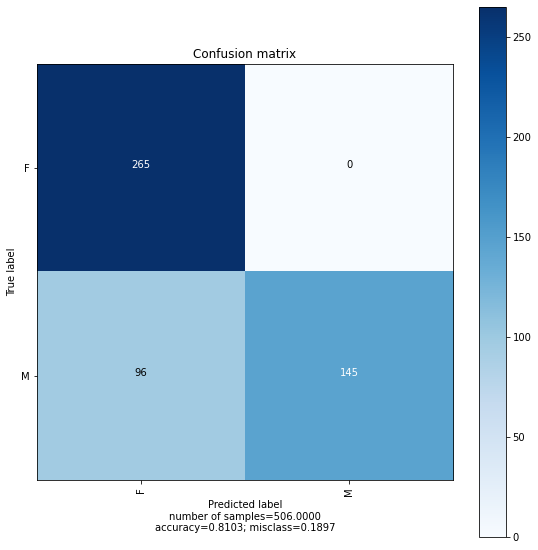

In [57]:
# calculate and plot the confusion matrix

conf_mat = confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(conf_mat, ['F', 'M'], title='Confusion matrix', cmap=None, normalize=False, file_name=None)

Using a simple Random Forest, we can see how we are able to perfectly distinguish the female class, but we have some problems for the male class (recall = 0.6). 

# SVM

In [58]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

svc = SVC(C = 1, gamma='auto', kernel='rbf', break_ties = True, class_weight='balanced', decision_function_shape='ovr', random_state=42, verbose=True)
# these parameters were defined after a param_tuning using sklearn.model_selection GridSearchCV

svc.fit(x_train, y_train)

[LibSVM]

SVC(C=1, break_ties=True, class_weight='balanced', gamma='auto',
    random_state=42, verbose=True)

In [59]:
# VALIDATION

y_train_pred = svc.predict(x_train)
print(classification_report(y_train, y_train_pred))
y_validation_pred = svc.predict(x_validation)
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

           F       1.00      1.00      1.00       942
           M       1.00      1.00      1.00       925

    accuracy                           1.00      1867
   macro avg       1.00      1.00      1.00      1867
weighted avg       1.00      1.00      1.00      1867

              precision    recall  f1-score   support

           F       1.00      1.00      1.00       167
           M       1.00      1.00      1.00       163

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330



In [60]:
#TEST

y_test_pred = svc.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           F       0.93      1.00      0.96       265
           M       1.00      0.91      0.95       241

    accuracy                           0.96       506
   macro avg       0.96      0.96      0.96       506
weighted avg       0.96      0.96      0.96       506



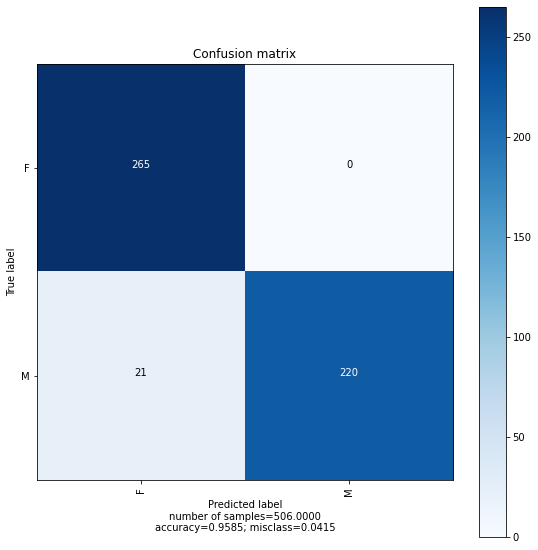

In [61]:
conf_mat = confusion_matrix(y_test, y_test_pred)


plot_confusion_matrix(conf_mat, ['F', 'M'], title='Confusion matrix', cmap=None, normalize=False, file_name=None)

As we can see, the SVC performs better than the Random Forest from each point of view: Precision, Recall and Accuracy. 
On the other hand, what we can notice is that the 'problems' are always with the Male class.

# Neural Network

The main idea here is to use the embeddings as the input of a NN composed by 2 linear layer. In this case we're not scaling the 
embeddings because the model guarantees best results in this way.
Since we're facing a binary classification problem a sigmoid activation function was applied in the last NN's layer, 
and SGD optimizer and binary cross-entropy loss were used. 

In [62]:
df_train_emb = calculate_band_metrics(df_train, 64)
df_validation_emb = calculate_band_metrics(df_validation, 64)
df_test_emb = calculate_band_metrics(df_test, 64)


Output()

Output()

Output()

In [63]:
class Linear_classifier(torch.nn.Module):
    def __init__(self):
        super(Linear_classifier, self).__init__()
       
        self.lin1 = torch.nn.Linear(64, 32)  
        self.lin2 = torch.nn.Linear(32, 1) 

    def forward(self, x):
        x = torch.tanh(self.lin1(x))
        x = torch.sigmoid(self.lin2(x))
        return x

In [66]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Linear_classifier().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [67]:
linear_model = training_validation_linear(model, df_train_emb, df_validation_emb, 64, 1000, 'Linear_classifier', True)

Output()

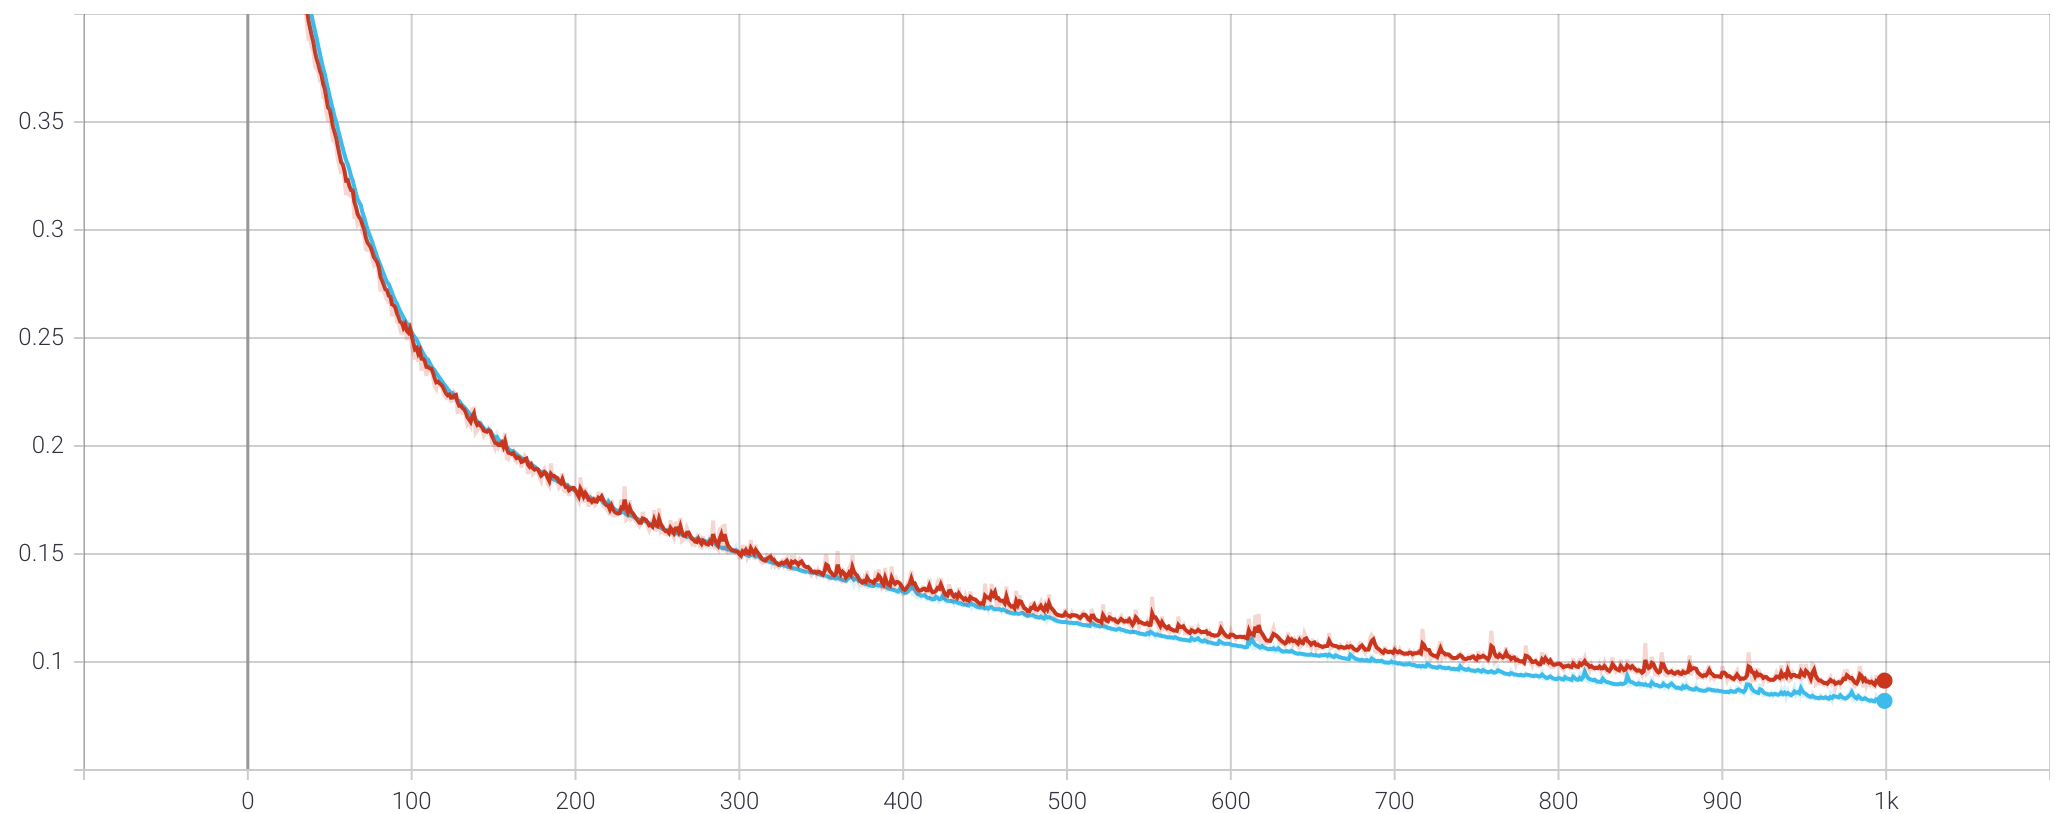

The chart above is a screen from tensorboard, the red line is the train_loss_mean and the blue line is the validation_loss_mean. The x-axis represents the training epochs while the y-axis the loss.

As we can see, the model is diminishing the error at each epochs and there are not overfitting problems

In [68]:
prediction = testing_linear(df_test_emb_scaled, linear_model)

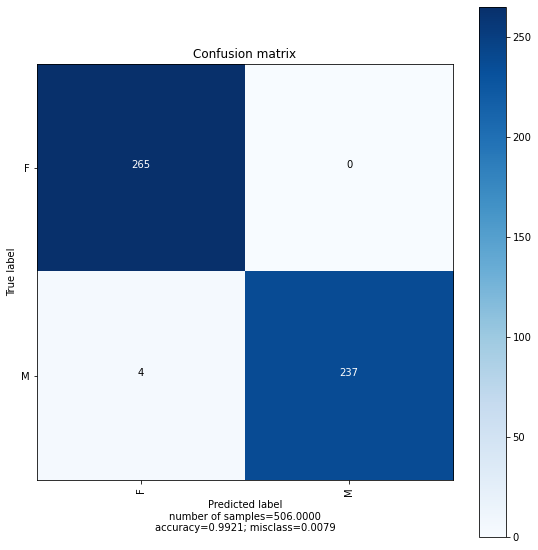

In [69]:
conf_mat = confusion_matrix(prediction.y_true, prediction.y_pred)


plot_confusion_matrix(conf_mat, ['F', 'M'], title='Confusion matrix', cmap=None, normalize=False, file_name=None)

In [70]:
print(classification_report(prediction.y_true, prediction.y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       265
           1       1.00      0.98      0.99       241

    accuracy                           0.99       506
   macro avg       0.99      0.99      0.99       506
weighted avg       0.99      0.99      0.99       506



with this NN, we've overcome the baseline defined with the random forest and the SVM classifier.

# CNN

The main idea here is to use a CNN followed by a flatten layer and a linear layer in order to classify the gender of the speaker. Since we're facing a binary classification problem a sigmoid activation function was applied in the last linear layer, and SGD optimizer and binary cross-entropy loss were used. In order to avoid overfitting on the training data, a Dropout was added after each convolutional layer.

Since the CNN needs the inputs to be of the same shape, we've decided to segment our data into 2 seconds chunks.

NOTE: to the CNN we're not giving as input the embeddings, but the original mfcc of each audio file. 

In [71]:
df_train_segmented = calculate_mfcc_segment(df_train.reset_index(drop=True), 64, 2)
df_validation_segmented = calculate_mfcc_segment(df_validation.reset_index(drop=True), 64, 2)
df_test_segmented = calculate_mfcc_segment(df_test.reset_index(drop=True), 64, 2)

Output()

Output()

Output()

In [72]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
       
        #Encoder
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size = 2, stride = 1)  
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 2, stride = 1) 
        self.conv3 = torch.nn.Conv2d(64, 1, kernel_size = 2, stride = 1) 
        
        self.MaxP1 = torch.nn.MaxPool2d(kernel_size = 2)
        self.drop = torch.nn.Dropout(p=0.1)
        self.flat = torch.nn.Flatten()
        self.lin = torch.nn.Linear(49, 1) 
        

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.MaxP1(x)
        x = self.drop(x)
        
        x = torch.relu(self.conv2(x))
        x = self.MaxP1(x)
        x = self.drop(x)
        
        x = torch.relu(self.conv3(x))
        x = self.MaxP1(x)
        x = self.drop(x)
        
        x = self.flat(x)
        x = torch.sigmoid(self.lin(x))
        compressed_representation = x
        
        return x

In [75]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [76]:
CNN_model = training_validation_CNN(model, df_train_segmented, df_validation_segmented, 64, 1000, 'CNN_classifier', True)

Output()

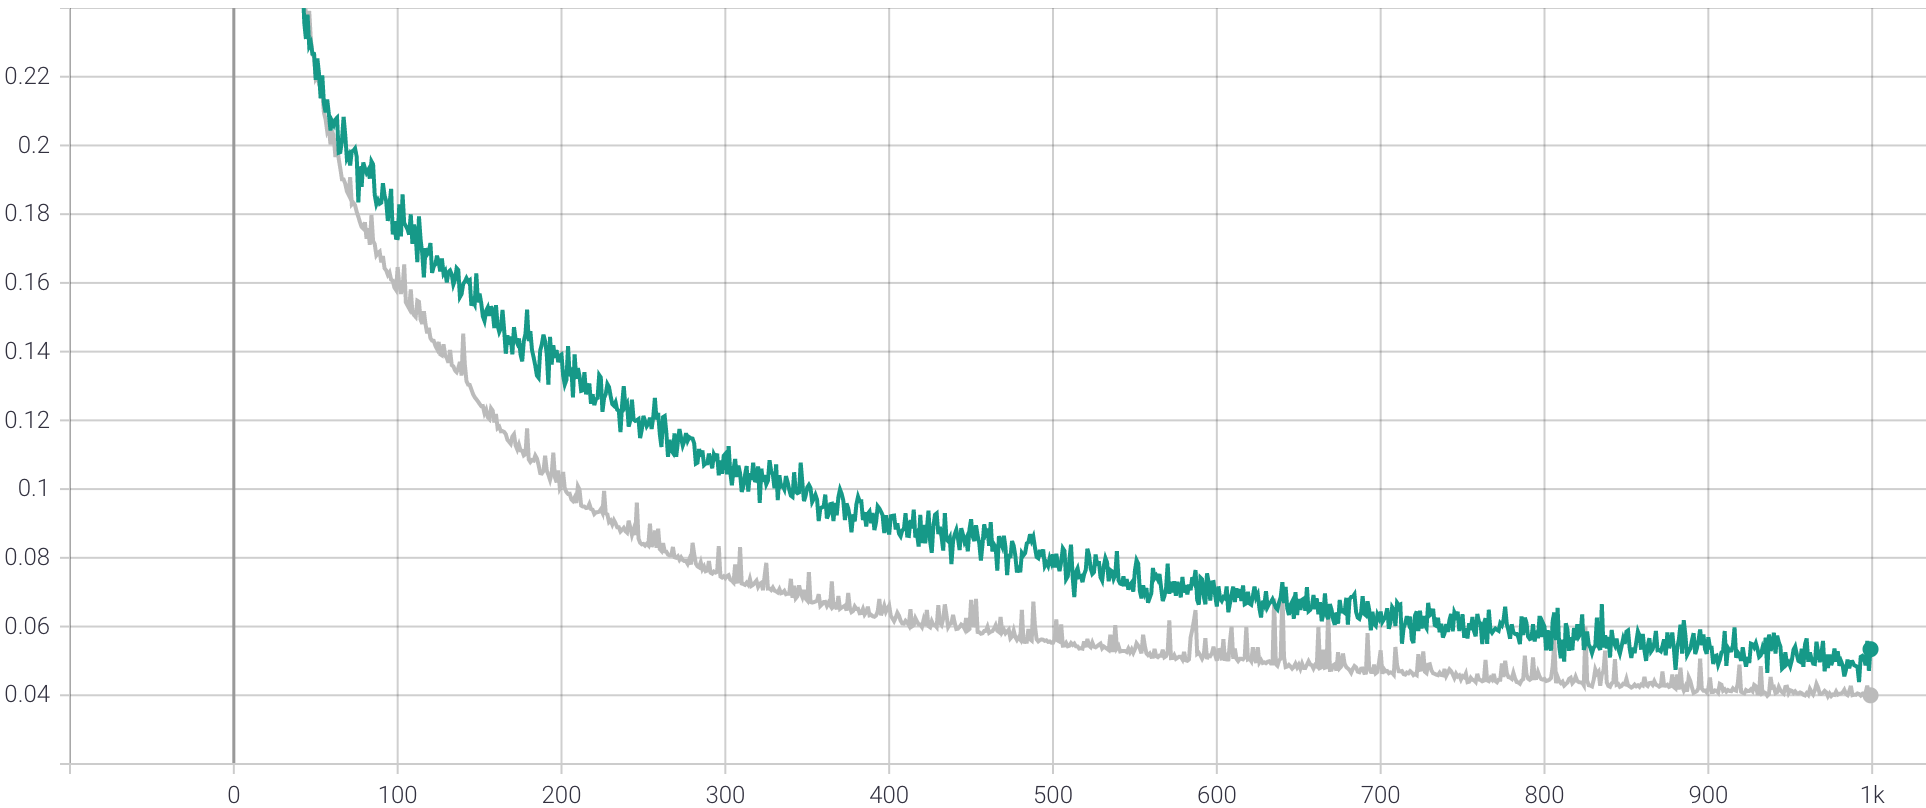

The chart above is a screen from tensorboard, the green line is the train_loss_mean and the grey line is the validation_loss_mean. The x-axis represents the training epochs while the y-axis the loss.

As we can see, the model is diminishing the error at each epochs and there are not overfitting problems

In [77]:
prediction = testing_CNN(df_test_segmented, CNN_model)

In [78]:
prediction

,y_true,y_pred,path
0,1,1.0,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
1,1,1.0,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
2,1,1.0,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
3,1,1.0,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
4,1,1.0,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
...,...,...,...
1697,0,0.0,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
1698,0,0.0,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
1699,0,0.0,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
1700,0,0.0,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...


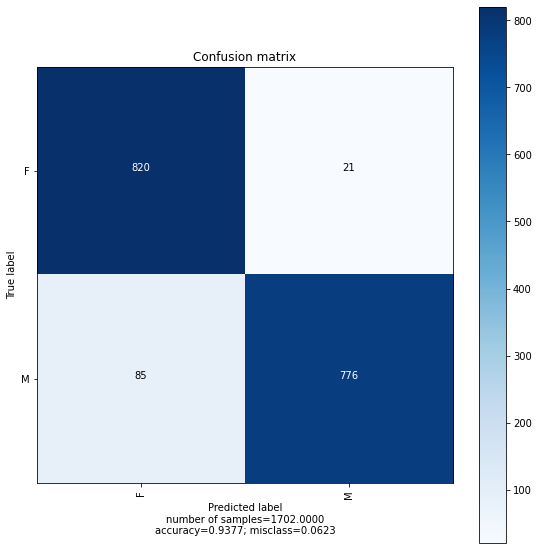

In [79]:
conf_mat = confusion_matrix(prediction.y_true, prediction.y_pred)


plot_confusion_matrix(conf_mat, ['F', 'M'], title='Confusion matrix', cmap=None, normalize=False, file_name=None)

In [80]:
print(classification_report(prediction.y_true, prediction.y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       841
           1       0.97      0.90      0.94       861

    accuracy                           0.94      1702
   macro avg       0.94      0.94      0.94      1702
weighted avg       0.94      0.94      0.94      1702



# Conclusion

Overall, the best model is the Linear_classifier with accuracy = 0,99. The CNN and the SVC reached good results, with the difference that SVC has the best tradeoff between accuracy obtained in the prediction and computational effort.

The better results obtained in the NN with respect to the CNN may be due to two main facts:
- the calculated embeddings, by doing the mean of each mel-band over the time dimension, are able to summarise more clearly the information needed for the gender classification than the embeddings generated from the Convolutional layers (before the flatten and the linear layers).
- some inefficiencies of the developed model (maybe the CNN can be optimized)